<a href="https://colab.research.google.com/github/cuducquang/Deep-Learning/blob/main/submission_s4021255_s3978616.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Group Project

**Student Name:** Cu Duc Quang & Nguyen Trong Tien  
**Student ID:** S4021255 & S3978616
**Course:** Deep Learning

# Multi-Task Learning for Spectral Signal Analysis

## 1. Introduction & Problem Formulation
This project addresses a Multi-Task Learning (MTL) problem involving spectral image data ($32 \times 32$ pixels). The objective is to simultaneously solve three distinct tasks from a single input signal:
1.  **Target A (Classification):** 10-class digit recognition.
2.  **Target B (Classification):** 32-class spectral pattern recognition.
3.  **Target C (Regression):** Continuous signal intensity estimation.

## 2. Theoretical Framework

### Multi-Task Learning (MTL)
Instead of training separate models for each task, we employ Hard Parameter Sharing, where a shared feature extraction backbone branches into task-specific heads. Theoretically, MTL improves generalization by inducing an inductive bias, forcing the model to learn representations that are robust across multiple related tasks (Caruana, 1997). This effectively acts as a regularizer, reducing the risk of overfitting on individual tasks with limited data.

> **Reference:** Caruana, R. (1997). "Multitask Learning". *Machine Learning*, 28, 41–75.

## 1 - Setup Frameworks and Libraries

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Concatenate, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers

## 2 - EDA

In [4]:
data = np.load('dataset_dev_3000.npz')
X = data['X']   # Input images
y = data['y']   # Multi-target labels

# 2. Decompose Targets for Analysis
# y[:, 0]: Target A (Classification 0-9)
# y[:, 1]: Target B (Classification 0-31)
# y[:, 2]: Target C (Regression 0-1)
y_target_A = y[:, 0].astype(int)
y_target_B = y[:, 1].astype(int)
y_target_C = y[:, 2]

print("Data Loaded Successfully")
print(f"X Shape: {X.shape} | Type: {X.dtype}")
print(f"y Shape: {y.shape} | Type: {y.dtype}")
print("-" * 30)
print(f"Target A (Class 10): Unique values: {np.unique(y_target_A)}")
print(f"Target B (Class 32): Unique values count: {len(np.unique(y_target_B))}")
print(f"Target C (Regress):  Range [{y_target_C.min():.4f}, {y_target_C.max():.4f}]")

Data Loaded Successfully
X Shape: (3000, 32, 32) | Type: float32
y Shape: (3000, 3) | Type: float32
------------------------------
Target A (Class 10): Unique values: [0 1 2 3 4 5 6 7 8 9]
Target B (Class 32): Unique values count: 32
Target C (Regress):  Range [0.0003, 0.9996]


The dataset loads successfully with `X` as 32x32 images and `y` containing 3 targets. Target A has 10 classes, Target B has 32 classes, and Target C is a continuous value roughly in [0,1].


In [5]:
# Check Pixel Intensity Statistics
print(" Pixel Value Statistics:")
print(f"Min : {X.min()}")
print(f"Max : {X.max()}")
print(f"Mean: {X.mean():.2f}")
print(f"Std : {X.std():.2f}")

# Check for Channel Dimension
if X.ndim == 3:
    print("Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.")
else:
    print("Images already have channel dimension.")

 Pixel Value Statistics:
Min : 5.5413776863133535e-05
Max : 6.8485941886901855
Mean: 0.81
Std : 0.74
Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.


The min/max/mean/std show pixel values are not yet normalized (max > 1). The final line indicates images are `(N, H, W)` so we need to add a channel dimension to match CNN input `(N, H, W, 1)`.

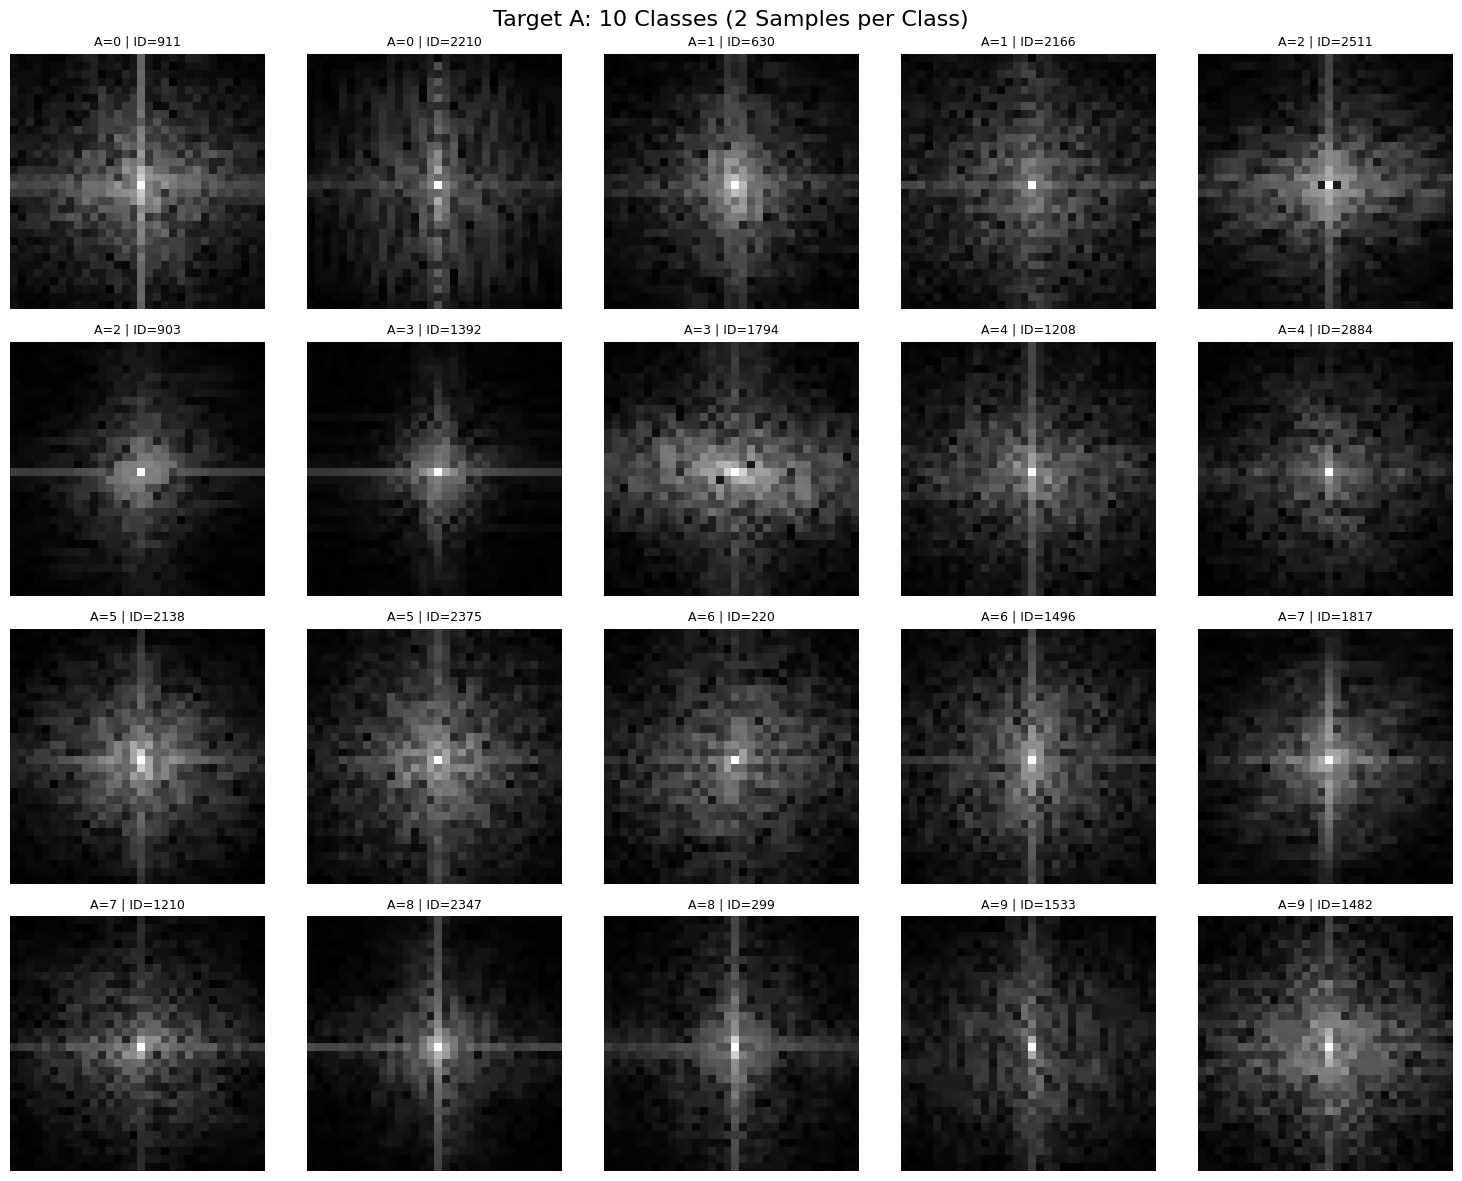

In [6]:
# Target A
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

The figure for Target A shows 2 sample images per class (10 classes). This is a quick visual sanity check to ensure labels and data look reasonable.

The 10-class grid shows a shared bright core with variations in streak direction and spread. Class-by-class notes from the two samples shown:
- Class 0: compact core + faint cross; moderate (similar to 1/2/5).
- Class 1: stronger vertical streak through the center; moderate, but close to 3/7/8.
- Class 2: diagonal/tilted streaks are more visible; moderate.
- Class 3: very strong vertical line + clear cross; easier than most.
- Class 4: broader, diffuse blob with weak streaks; harder.
- Class 5: wider halo with a noticeable horizontal bar; moderate.
- Class 6: noisy, diffuse blob with weak structure; harder.
- Class 7: vertical line present but background is noisy; moderate-hard.
- Class 8: thin vertical bar with faint cross; moderate (confusable with 1/3/7/9).
- Class 9: compact bright core with mixed streaks; moderate-hard.

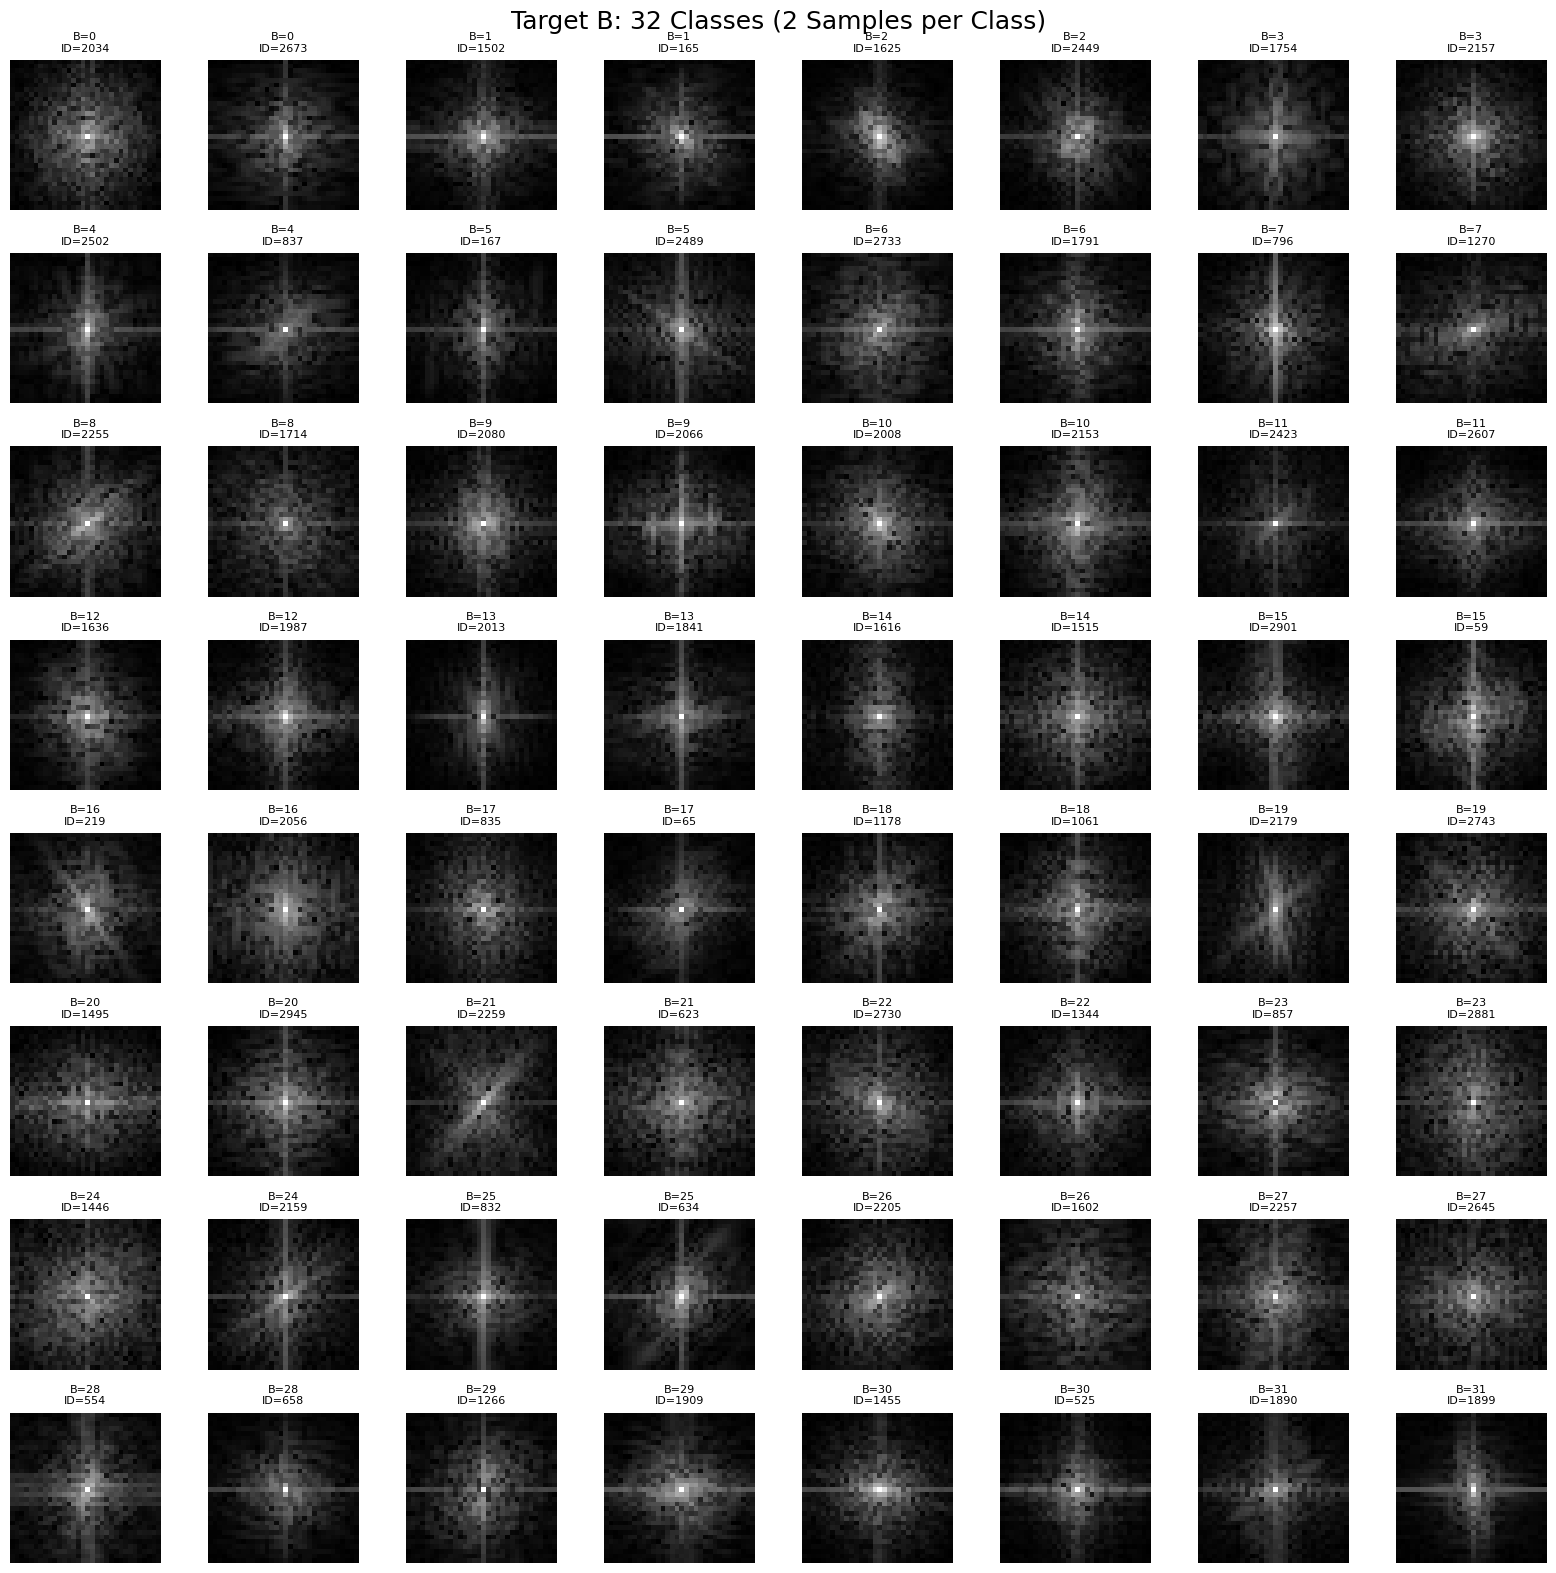

In [7]:
# Target B
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

plot_idx = 0
for cls in range(32):
    cls_indices = np.where(y_target_B == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"B={cls}\nID={idx}", fontsize=8)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target B: 32 Classes (2 Samples per Class)", fontsize=18)
plt.tight_layout()
plt.show()

The figure for Target B shows 2 sample images per class (32 classes). The goal is to quickly check diversity and whether classes have visually distinguishable patterns.

The 32-class grid shows high intra-class variation. Notes per class based on the two samples displayed:
- Class 0: compact blob vs thin vertical line; hard (high variance).
- Class 1: compact blob both samples; moderate.
- Class 2: blob vs strong diagonal streak; hard.
- Class 3: clear cross in both; easier.
- Class 4: diagonal streak vs vertical cross; hard.
- Class 5: vertical spike vs diffuse blob; hard.
- Class 6: diffuse blob vs vertical line; hard.
- Class 7: diffuse/horizontal glow vs vertical line; hard.
- Class 8: vertical line vs diffuse blob; hard.
- Class 9: horizontal bar vs vertical-ish core; hard.
- Class 10: diffuse haze vs vertical line; hard.
- Class 11: diffuse blobs in both; moderate but not distinctive.
- Class 12: blob vs strong vertical line; hard.
- Class 13: blob vs clearer cross; hard.
- Class 14: compact central point in both; easier/moderate.
- Class 15: strong vertical line in both; easier.
- Class 16: horizontal bar vs vertical line; hard.
- Class 17: vertical line vs diagonal-ish blob; hard.
- Class 18: diagonal streak vs vertical line; hard.
- Class 19: vertical line vs diffuse blob; hard.
- Class 20: vertical line vs diffuse blob; hard.
- Class 21: diagonal-leaning blobs in both; moderate.
- Class 22: star/diagonal streaks vs diffuse blob; hard.
- Class 23: diffuse blob vs sharp diagonal line; hard (high variance).
- Class 24: blob vs vertical line; hard.
- Class 25: horizontal bar vs diffuse blob; hard.
- Class 26: diffuse blob vs vertical line; hard.
- Class 27: compact blobs in both; moderate.
- Class 28: vertical line in both; easier.
- Class 29: vertical line in both; easier.
- Class 30: diffuse blobs in both; moderate (confusable).
- Class 31: strong horizontal band/stripe in both; easier.

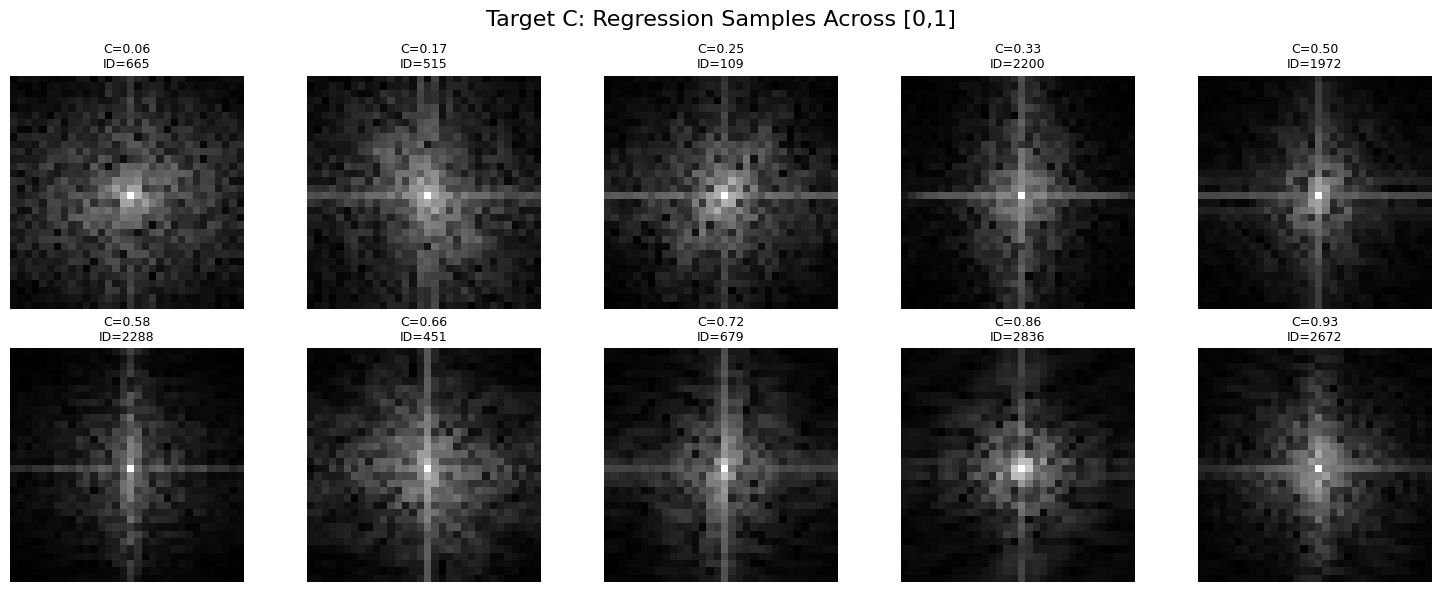

In [8]:
# Target C
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

bins = np.linspace(0, 1, 11)

selected_indices = []
for i in range(10):
    bin_indices = np.where(
        (y_target_C >= bins[i]) & (y_target_C < bins[i+1])
    )[0]
    if len(bin_indices) > 0:
        selected_indices.append(np.random.choice(bin_indices))

for ax, idx in zip(axes, selected_indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"C={y_target_C[idx]:.2f}\nID={idx}", fontsize=9)
    ax.axis('off')

fig.suptitle("Target C: Regression Samples Across [0,1]", fontsize=16)
plt.tight_layout()
plt.show()

Samples are selected across Target C value bins to check coverage over [0,1] and whether the images differ visually across the range.

The regression samples show how appearance changes across the value range. Notes per bin from the displayed examples:
- C≈0.00: bright core with a strong vertical streak.
- C≈0.11: diffuse blob, weak streaks.
- C≈0.26: clearer horizontal bar with a mild cross.
- C≈0.31: narrow vertical line, compact core.
- C≈0.44: cross-like structure (both axes visible).
- C≈0.59: strong vertical line again.
- C≈0.65: strong cross (vertical + horizontal).
- C≈0.76: noisy, diffuse pattern with weak lines.
- C≈0.83: diagonal smear/off-axis energy.
- C≈0.94: strong horizontal band.
Overall, the visual patterns do not change monotonically with C, so regression likely relies on subtle cues rather than a single obvious trend.

Target A Balance Check: {np.int64(0): np.int64(290), np.int64(1): np.int64(304), np.int64(2): np.int64(311), np.int64(3): np.int64(305), np.int64(4): np.int64(306), np.int64(5): np.int64(294), np.int64(6): np.int64(290), np.int64(7): np.int64(291), np.int64(8): np.int64(310), np.int64(9): np.int64(299)}


/tmp/ipython-input-1890465473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_A, palette='viridis')


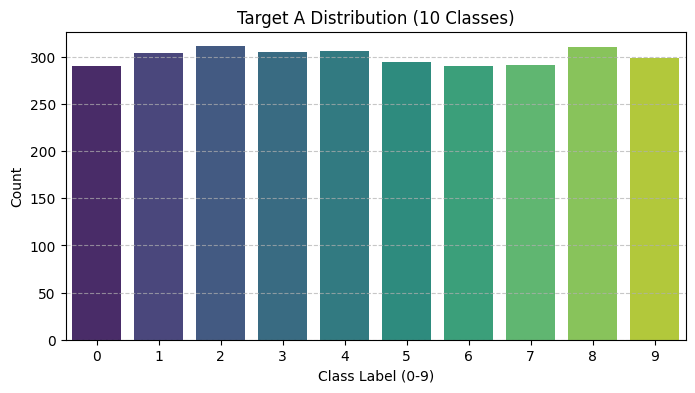

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_target_A, palette='viridis')
plt.title("Target A Distribution (10 Classes)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Check exact counts
unique, counts = np.unique(y_target_A, return_counts=True)
print("Target A Balance Check:", dict(zip(unique, counts)))
plt.show()

Target A is fairly balanced across 10 classes (counts are similar).

/tmp/ipython-input-1059615394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_B, palette='magma')


Target B - Min samples per class: 75
Target B - Max samples per class: 113


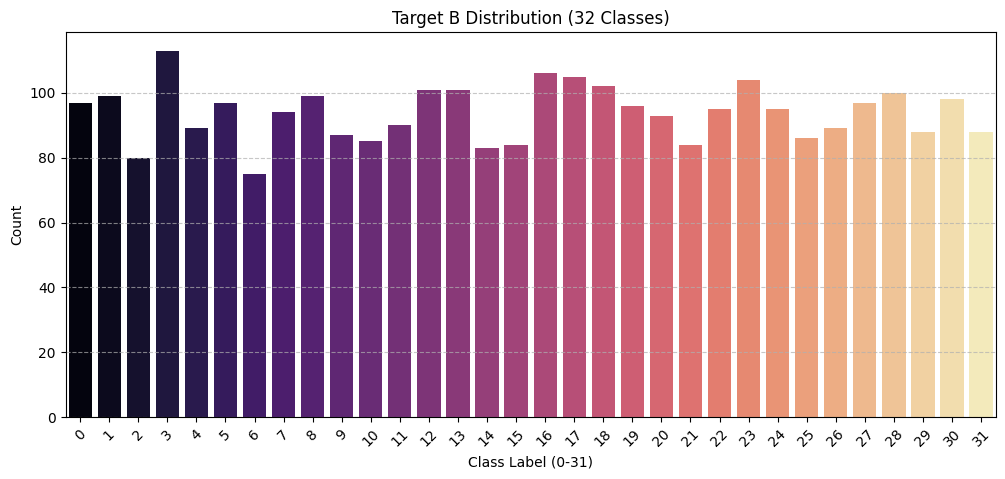

In [10]:
plt.figure(figsize=(12, 5))
sns.countplot(x=y_target_B, palette='magma')
plt.title("Target B Distribution (32 Classes)")
plt.xlabel("Class Label (0-31)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Statistics for Target B
unique_b, counts_b = np.unique(y_target_B, return_counts=True)
print(f"Target B - Min samples per class: {counts_b.min()}")
print(f"Target B - Max samples per class: {counts_b.max()}")
plt.show()

The Target B countplot shows per-class counts range from 75 to 113, indicating mild imbalance.

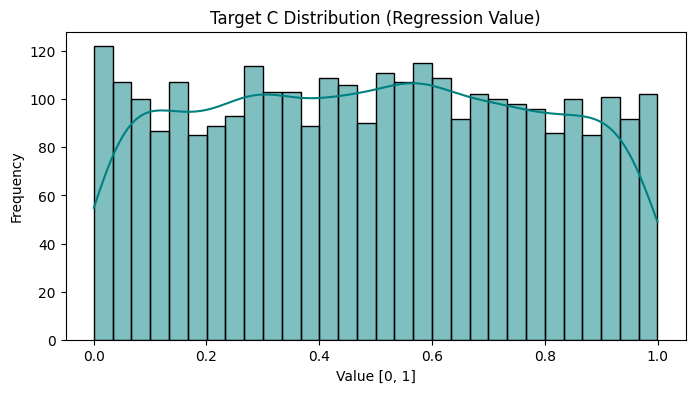

In [11]:
plt.figure(figsize=(8, 4))
sns.histplot(y_target_C, kde=True, bins=30, color='teal')
plt.title("Target C Distribution (Regression Value)")
plt.xlabel("Value [0, 1]")
plt.ylabel("Frequency")
plt.show()

The histogram (with KDE) shows the distribution of Target C in [0,1]. Skewness indicates whether the regression values cluster in certain ranges or are more uniform.

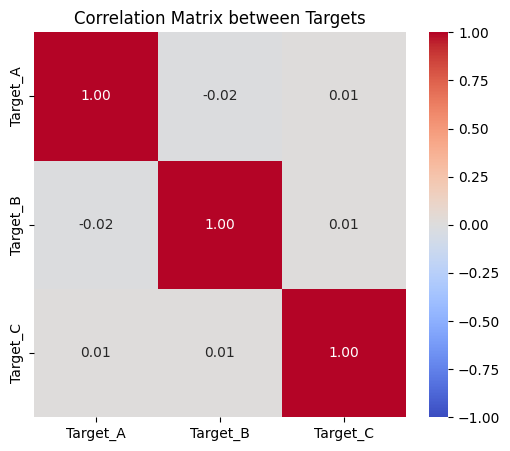

In [12]:
# Create a DataFrame for correlation checking
df_targets = pd.DataFrame({
    'Target_A': y_target_A,
    'Target_B': y_target_B,
    'Target_C': y_target_C
})

# Compute Correlation Matrix
corr_matrix = df_targets.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Targets")
plt.show()

The heatmap shows correlations among the three targets. Values near 0 indicate weak relationships, while large positive/negative values indicate stronger associations.


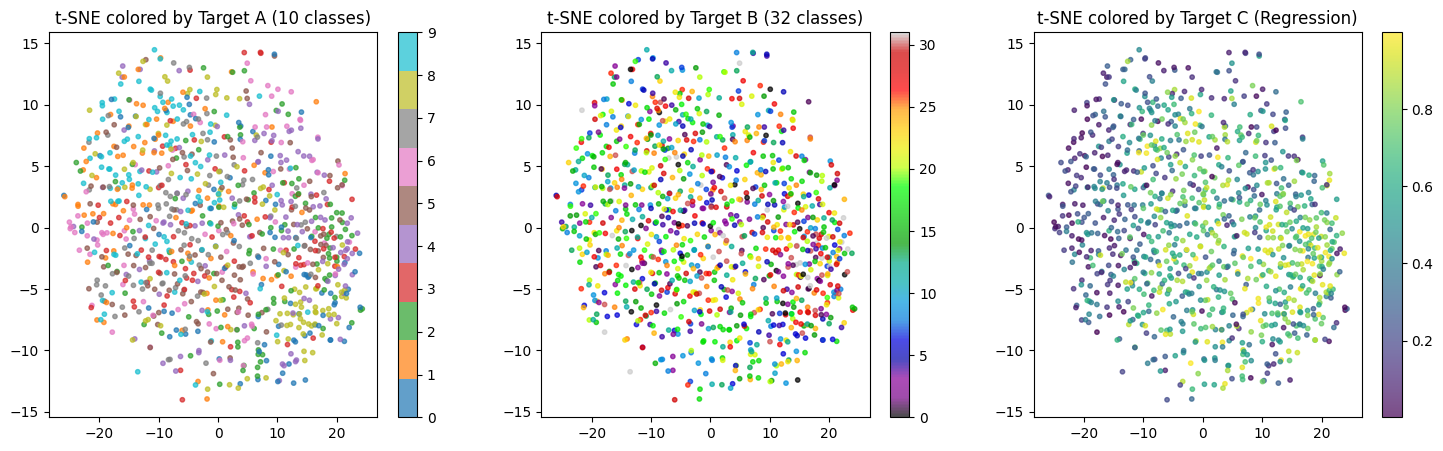

In [13]:
# Subsample for speed (1000 samples)
idx_subset = np.random.choice(len(X), 1000, replace=False)
X_tsne_input = X[idx_subset].reshape(1000, -1)
y_tsne_A = y_target_A[idx_subset]
y_tsne_B = y_target_B[idx_subset]
y_tsne_C = y_target_C[idx_subset]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_tsne_input)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot colored by Target A
scatter1 = axes[0].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_A, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("t-SNE colored by Target A (10 classes)")
plt.colorbar(scatter1, ax=axes[0])

# Plot colored by Target B
scatter2 = axes[1].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_B, cmap='nipy_spectral', s=10, alpha=0.7)
axes[1].set_title("t-SNE colored by Target B (32 classes)")
plt.colorbar(scatter2, ax=axes[1])

# Plot colored by Target C
scatter3 = axes[2].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_C, cmap='viridis', s=10, alpha=0.7)
axes[2].set_title("t-SNE colored by Target C (Regression)")
plt.colorbar(scatter3, ax=axes[2])

plt.show()

The t-SNE visualizations project high-dimensional image features into a 2D space, with points colored according to each target variable. This analysis helps assess the intrinsic separability of the dataset and the relative difficulty of each learning task.

**Target A (10-class classification):**  
The samples corresponding to different classes are highly intermixed, with no clearly separable clusters. This suggests weak class separability in the feature space, indicating that linear models may struggle to distinguish between classes. Effective learning for this target likely requires non-linear models and robust feature representations.

**Target B (32-class classification):**  
Compared to Target A, this target exhibits even greater overlap among classes. The high number of categories combined with the absence of distinct clusters indicates a highly challenging classification problem. Models trained on this target may suffer from class confusion and require more advanced architectures or alternative strategies such as hierarchical classification or metric learning.

**Target C (Regression):**  
Unlike the classification targets, the regression target displays a smoother and more continuous color gradient across the embedding space. This suggests that the target values vary gradually with the underlying feature structure, making the regression task more suitable for learning. Continuous models are expected to perform better on this target compared to discrete classification tasks.

Overall, the t-SNE results indicate that the dataset is inherently complex, particularly for multi-class classification. Among the three targets, the regression task appears to be the most amenable to effective modeling.


## 3 - Data Preprocessing Strategy

### 3.1. Dynamic Range Compression (Log Transformation)
Spectral data (magnitude spectrum) typically exhibits a heavy-tailed distribution where low-frequency components (DC) have magnitudes orders significantly larger than high-frequency details. Standard linear normalization would cause the model to focus solely on high-energy peaks, treating subtle but informative spectral lines as noise.

To address this, we apply a logarithmic transformation:
$$X_{log} = \ln(1 + X_{raw})$$

This compression technique preserves the structure of high-energy components while amplifying the visibility of low-energy features, which is critical for pattern recognition in frequency domains (Oppenheim & Schafer, 2010).

> **Reference:** Oppenheim, A. V., & Schafer, R. W. (2010). *Discrete-Time Signal Processing*. Pearson.

### 3.2. Center Masking (DC Component Removal)
Exploratory Data Analysis (EDA) revealed a dominant DC component (zero-frequency term) at the center of the spectrum ($16, 16$). This high-energy artifact creates a "blinding" effect for the attention mechanism. We apply a spatial mask to zero out this component, forcing the model to attend to the distributed spectral features.

In [14]:
# 1. Normalize & Reshape
X_float = X.astype('float32')
X_log = np.log1p(X_float)

MAX_LOG_VALUE = X_log.max()
X_norm = X_log / MAX_LOG_VALUE
X_norm = np.expand_dims(X_norm, axis=-1) # (3000, 32, 32, 1)

# 2. Decompose Targets
y_A_raw = y[:, 0].astype(int)   # Class 0-9
y_B_raw = y[:, 1].astype(int)   # Class 0-31
y_C_raw = y[:, 2].astype(float) # Regression

# 3. Split Data (Train 70% - Val 15% - Test 15%)
# Split 1: Train vs Temp
X_train, X_temp, yA_train, yA_temp, yB_train, yB_temp, yC_train, yC_temp = train_test_split(
    X_norm, y_A_raw, y_B_raw, y_C_raw,
    test_size=0.3, random_state=42, stratify=y_B_raw
)

# Split 2: Val vs Test
X_val, X_test, yA_val, yA_test, yB_val, yB_test, yC_val, yC_test = train_test_split(
    X_temp, yA_temp, yB_temp, yC_temp,
    test_size=0.5, random_state=42, stratify=yB_temp
)

# 4. Target Encoding
# Target C: Reshape to (N, 1) for Regression
yC_train_reg = yC_train.reshape(-1, 1)
yC_val_reg   = yC_val.reshape(-1, 1)
yC_test_reg  = yC_test.reshape(-1, 1)

print(f"Train Set: {X_train.shape}")
print(f"Val Set:   {X_val.shape}")
print(f"Test Set:  {X_test.shape}")
print(f"Target A (Train) shape: {yA_train.shape} (Sparse/Integer)")

Train Set: (2100, 32, 32, 1)
Val Set:   (450, 32, 32, 1)
Test Set:  (450, 32, 32, 1)
Target A (Train) shape: (2100,) (Sparse/Integer)


These lines confirm the train/val/test split sizes (70/15/15) after normalization and channel expansion. `Target A (Train)` is an integer (sparse) label vector, matching `SparseCategoricalCrossentropy`.

The printed shapes confirm a 3000-sample dataset split into 2100/450/450 (70/15/15). This ratio gives a large enough training set to learn stable features, while still reserving sufficient validation and test samples to measure generalization reliably (450 each is large enough to estimate accuracy/MAE without being too noisy). The earlier class-count output shows Target B has 32 classes with some variability in class frequencies, so we stratify on `y_B` to preserve that class distribution across train/val/test. Stratifying on the most fine-grained classification target reduces the risk of rare classes being underrepresented in validation/test, which would otherwise make evaluation unstable and bias multi-task training.


In [15]:
# A. Train Datagen
train_datagen = ImageDataGenerator()

# B. Val/Test Datagen
val_datagen = ImageDataGenerator()

def multi_output_data_generator(X, yA, yB, yC, batch_size, datagen):
    indices = np.arange(len(X))
    gen_X = datagen.flow(X, indices, batch_size=batch_size, shuffle=True)

    while True:
        X_batch, idx_batch = next(gen_X)
        yA_batch = yA[idx_batch]
        yB_batch = yB[idx_batch]
        yC_batch = yC[idx_batch]

        yield X_batch, {
            'output_A': yA_batch,
            'output_B': yB_batch,
            'output_C': yC_batch
        }

BATCH_SIZE = 32

train_gen = multi_output_data_generator(
    X_train, yA_train, yB_train, yC_train_reg,
    batch_size=BATCH_SIZE,
    datagen=train_datagen
)

val_gen = multi_output_data_generator(
    X_val, yA_val, yB_val, yC_val_reg,
    batch_size=BATCH_SIZE,
    datagen=val_datagen
)

This section defines data augmentation and a custom multi-output generator for the three tasks. `train_datagen` is where augmentation could be enabled (currently commented out), while `val_datagen` performs no augmentation to keep validation unbiased. The wrapper uses indices from the image generator to fetch the aligned labels for A, B, and C, ensuring each batch returns a single image batch with a dictionary of three label arrays. `BATCH_SIZE=32` controls batch size, and `train_gen`/`val_gen` are the generators used during training and validation.

## 4 - Experiments

### VIT

In [30]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, X, yA, yB, yC):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N,32,32,1)
        self.yA = torch.tensor(yA, dtype=torch.long)
        self.yB = torch.tensor(yB, dtype=torch.long)
        self.yC = torch.tensor(yC, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1)  # (1,32,32)

        # Resize to 224x224
        x = F.interpolate(
            x.unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return (
            x,
            torch.tensor(self.yA[idx], dtype=torch.long),
            torch.tensor(self.yB[idx], dtype=torch.long),
            torch.tensor(self.yC[idx], dtype=torch.float32)
        )

In [31]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(8),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.Resize((224, 224)),  # ViT requires fixed size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [32]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [33]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [34]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    MultiTaskDataset(X_train, yA_train, yB_train, yC_train_reg),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    MultiTaskDataset(X_val, yA_val, yB_val, yC_val_reg),
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    MultiTaskDataset(X_test, yA_test, yB_test, yC_test_reg),
    batch_size=32,
    shuffle=False
)

In [16]:
!pip install timm

In [17]:
import timm
import torch.nn as nn

vit = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=True
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [18]:
vit.patch_embed.proj = nn.Conv2d(
    1, vit.embed_dim,
    kernel_size=vit.patch_embed.proj.kernel_size,
    stride=vit.patch_embed.proj.stride
)

In [19]:
embed_dim = vit.head.in_features
vit.head = nn.Identity()  # remove original classifier

class MultiTaskHead(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.headA = nn.Linear(embed_dim, 10)
        self.headB = nn.Linear(embed_dim, 32)
        self.headC = nn.Linear(embed_dim, 1)

    def forward(self, x):
        cls_token = x[:, 0, :]  # take CLS token

        return (
            self.headA(cls_token),
            self.headB(cls_token),
            self.headC(cls_token)
        )

multitask_head = MultiTaskHead(embed_dim)

In [20]:
class ViTMultiTask(nn.Module):
    def __init__(self, vit, head):
        super().__init__()
        self.vit = vit
        self.head = head

    def forward(self, x):
        x = self.vit.forward_features(x)
        return self.head(x)

model = ViTMultiTask(vit, multitask_head)

In [21]:
for param in model.vit.parameters():
    param.requires_grad = False

In [22]:
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()
lossC = nn.SmoothL1Loss()  # Huber equivalent

def compute_loss(preds, targets):
    pA, pB, pC = preds
    yA, yB, yC = targets

    return (
        lossA(pA, yA) +
        2.0 * lossB(pB, yB) +
        0.3 * lossC(pC.squeeze(), yC)
    )

In [23]:
def train_one_epoch(model, loader, optimizer, criterions, device):
    model.train()

    total_loss = 0.0
    total_lossA = 0.0
    total_lossB = 0.0
    total_lossC = 0.0
    correctA = 0
    correctB = 0
    total_maeC = 0.0
    total = 0

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        optimizer.zero_grad()
        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC.squeeze())

        loss = lossA + lossB + lossC
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_lossA += lossA.item()
        total_lossB += lossB.item()
        total_lossC += lossC.item()

        correctA += (outA.argmax(dim=1) == yA).sum().item()
        correctB += (outB.argmax(dim=1) == yB).sum().item()
        total += yA.size(0)

        # MAE for Task C
        total_maeC += torch.abs(outC.squeeze() - yC.squeeze()).sum().item()

    avg_loss = total_loss / len(loader)
    avg_lossA = total_lossA / len(loader)
    avg_lossB = total_lossB / len(loader)
    avg_lossC = total_lossC / len(loader)
    accA = correctA / total
    accB = correctB / total
    maeC = total_maeC / total

    return avg_lossA, avg_lossB, avg_lossC, accA, accB, maeC

In [25]:
import torch
@torch.no_grad()
def validate(model, dataloader, criterions, device,
             loss_weights={'A': 1.0, 'B': 2.0, 'C': 0.3}):

    model.eval()
    total_loss = 0.0
    total_lossA = 0.0
    total_lossB = 0.0
    total_lossC = 0.0
    correct_A = 0
    correct_B = 0
    total_maeC = 0.0
    total = 0

    for images, yA, yB, yC in dataloader:
        images = images.to(device)
        yA = yA.to(device)
        yB = yB.to(device)
        yC = yC.to(device)

        outA, outB, outC = model(images)

        loss_A = criterions['A'](outA, yA)
        loss_B = criterions['B'](outB, yB)
        loss_C = criterions['C'](outC.squeeze(), yC.squeeze())

        loss = (
            loss_weights['A'] * loss_A +
            loss_weights['B'] * loss_B +
            loss_weights['C'] * loss_C
        )

        total_loss += loss.item()
        total_lossA += loss_A.item()
        total_lossB += loss_B.item()
        total_lossC += loss_C.item()

        pred_A = outA.argmax(dim=1)
        pred_B = outB.argmax(dim=1)
        pred_C = outC.squeeze()

        correct_A += (pred_A == yA).sum().item()
        correct_B += (pred_B == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(pred_C - yC.squeeze()).sum().item()

    acc_A = correct_A / total
    acc_B = correct_B / total
    maeC = total_maeC / total

    return (
        total_lossA / len(dataloader),
        total_lossB / len(dataloader),
        total_lossC / len(dataloader),
        acc_A,
        acc_B,
        maeC
    )

In [26]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [27]:
criterions = {
    'A': torch.nn.CrossEntropyLoss(),
    'B': torch.nn.CrossEntropyLoss(),
    'C': torch.nn.SmoothL1Loss()  # Huber
}

In [28]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

In [35]:
WARMUP_EPOCHS = 20
for epoch in range(WARMUP_EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_acc_A, train_acc_B, train_mae_C = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_mae_C = validate(
        model, val_loader, criterions, device
    )

    print(
        f"Epoch [{epoch+1}/{WARMUP_EPOCHS}] | "
        f"Train Loss: {train_loss_A:}, {train_loss_B:}, {train_loss_C:} | "
        f"Val Loss: {val_loss_A:}, {val_loss_B:}, {val_loss_C:} | "
        f"Train Acc: {train_acc_A}, {train_acc_B}, {train_mae_C} | "
        f"Val Acc: {val_accA:.4f}, {val_accB:.4f}, {val_mae_C:.4f}"
    )

/tmp/ipython-input-2759427372.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2759427372.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2759427372.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


Epoch [1/20] | Train Loss: 2.3857428232828775, 3.7340640010255757, 0.10014276093605792 | Val Loss: 2.217852544784546, 3.5716042359670004, 0.04229113360246022 | Train Acc: 0.11428571428571428, 0.025714285714285714, 0.3453396011534191 | Val Acc: 0.1867, 0.0511, 0.2342
Epoch [2/20] | Train Loss: 2.2378214489329946, 3.589481548829512, 0.042917818762362 | Val Loss: 2.133079187075297, 3.6170029799143473, 0.03700961514065663 | Train Acc: 0.16142857142857142, 0.03666666666666667, 0.23253569693792434 | Val Acc: 0.1956, 0.0289, 0.2171
Epoch [3/20] | Train Loss: 2.182280339977958, 3.554404374324914, 0.036602018513914314 | Val Loss: 2.1301348129908244, 3.50403577486674, 0.03526218831539154 | Train Acc: 0.19952380952380952, 0.03761904761904762, 0.216755234173366 | Val Acc: 0.2333, 0.0378, 0.2169
Epoch [4/20] | Train Loss: 2.1553175882859663, 3.5356880751523105, 0.034734776836227284 | Val Loss: 2.1168574968973797, 3.5555825074513754, 0.038398142283161484 | Train Acc: 0.2261904761904762, 0.0428571428

In [36]:
for param in model.parameters():
    param.requires_grad = True

In [37]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

In [38]:
EPOCHS = 100

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=0.1, total_iters=10
        ),
        torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=EPOCHS - 10
        )
    ],
    milestones=[10]
)

In [39]:
train_losses_A = []
train_losses_B = []
train_losses_C = []
val_losses_A = []
val_losses_B = []
val_losses_C = []
train_accA_list = []
val_accA_list = []
train_accB_list = []
val_accB_list = []
train_maeC_list = []
val_maeC_list = []

for epoch in range(EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_acc_A, train_acc_B, train_mae_C = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_mae_C = validate(
        model, val_loader, criterions, device
    )

    scheduler.step()

    train_losses_A.append(train_loss_A)
    val_losses_A.append(val_loss_A)
    train_losses_B.append(train_loss_B)
    val_losses_B.append(val_loss_B)
    train_losses_C.append(train_loss_C)
    val_losses_C.append(val_loss_C)
    train_accA_list.append(train_acc_A)
    val_accA_list.append(val_accA)
    train_accB_list.append(train_acc_B)
    val_accB_list.append(val_accB)
    train_maeC_list.append(train_mae_C)
    val_maeC_list.append(val_mae_C)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss_A}, {train_loss_B:}, {train_loss_C:} | "
        f"Val Loss: {val_loss_A}, {val_loss_B}, {val_loss_C} | "
        f"Train Acc: {train_acc_A}, {train_acc_B}, {train_mae_C} | "
        f"Val Acc: {val_accA:.4f}, {val_accB:.4f}, {val_mae_C:.4f}"
    )


/tmp/ipython-input-2759427372.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2759427372.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2759427372.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


Epoch [1/100] | Train Loss: 2.9387137348001655, 3.9277795733827534, 0.17529989863661202 | Val Loss: 2.36253072420756, 3.517760896682739, 0.031808636089166 | Train Acc: 0.11523809523809524, 0.03190476190476191, 0.420157007035755 | Val Acc: 0.1133, 0.0378, 0.2195
Epoch [2/100] | Train Loss: 2.310933019175674, 3.5545744679190894, 0.043350097807970916 | Val Loss: 2.253789949417114, 3.5484580039978026, 0.0719031830628713 | Train Acc: 0.1461904761904762, 0.03, 0.24128993079775857 | Val Acc: 0.1267, 0.0356, 0.3230
Epoch [3/100] | Train Loss: 2.2375856872760886, 3.5586495941335503, 0.040641143466487076 | Val Loss: 2.2075058937072756, 3.545822763442993, 0.04126516127338012 | Train Acc: 0.1838095238095238, 0.03428571428571429, 0.2328720532144819 | Val Acc: 0.1911, 0.0467, 0.2423
Epoch [4/100] | Train Loss: 2.182980087670413, 3.5141987692226064, 0.040498773708488 | Val Loss: 2.144555377960205, 3.4316057999928793, 0.030108174805839858 | Train Acc: 0.20523809523809525, 0.041428571428571426, 0.23436

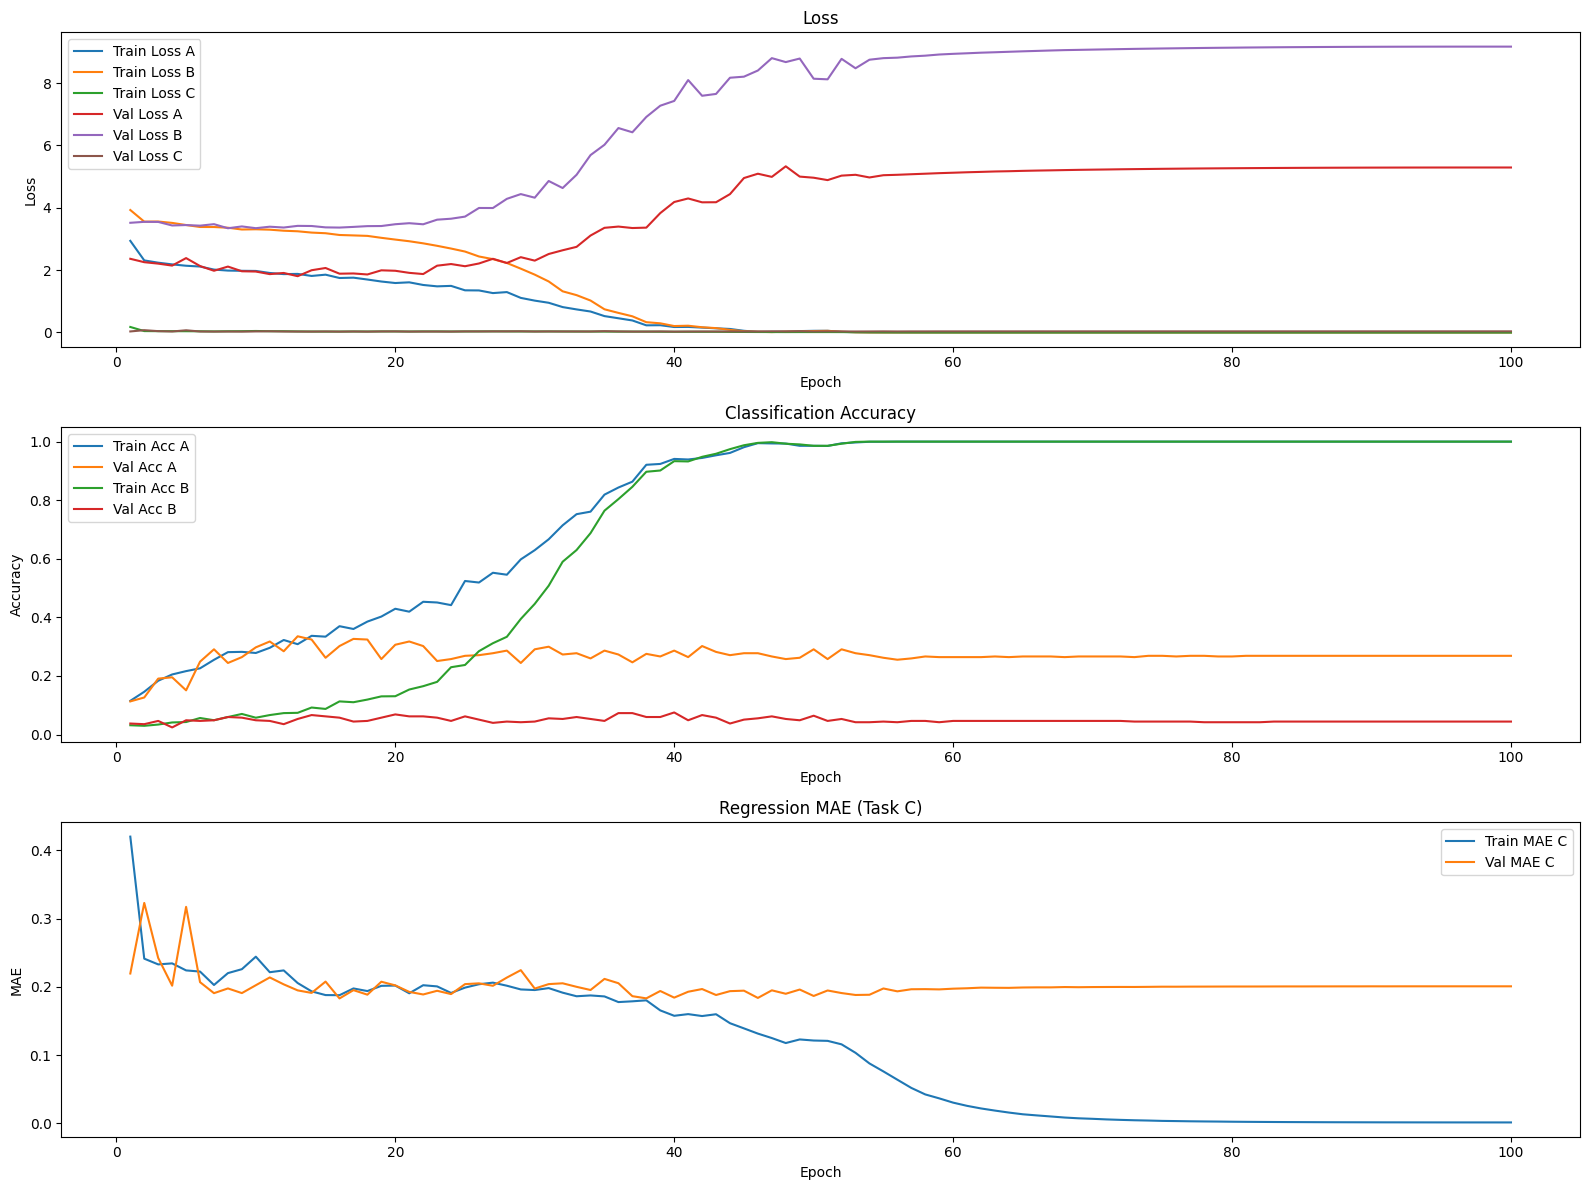

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(16, 12))

# Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses_A, label='Train Loss A')
plt.plot(epochs, train_losses_B, label='Train Loss B')
plt.plot(epochs, train_losses_C, label='Train Loss C')
plt.plot(epochs, val_losses_A, label='Val Loss A')
plt.plot(epochs, val_losses_B, label='Val Loss B')
plt.plot(epochs, val_losses_C, label='Val Loss C')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy A & B
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accA_list, label='Train Acc A')
plt.plot(epochs, val_accA_list, label='Val Acc A')
plt.plot(epochs, train_accB_list, label='Train Acc B')
plt.plot(epochs, val_accB_list, label='Val Acc B')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# MAE C
plt.subplot(3, 1, 3)
plt.plot(epochs, train_maeC_list, label='Train MAE C')
plt.plot(epochs, val_maeC_list, label='Val MAE C')
plt.title('Regression MAE (Task C)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### CNN + Hybrid

In [42]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, X, yA, yB, yC):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N,32,32,1)
        self.yA = torch.tensor(yA, dtype=torch.long)
        self.yB = torch.tensor(yB, dtype=torch.long)
        self.yC = torch.tensor(yC, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1)  # (1,32,32)
        return (
            x,
            torch.tensor(self.yA[idx], dtype=torch.long),
            torch.tensor(self.yB[idx], dtype=torch.long),
            torch.tensor(self.yC[idx], dtype=torch.float32)
        )

In [43]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(8),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.Resize((224, 224)),  # ViT requires fixed size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [44]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [45]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [46]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    MultiTaskDataset(X_train, yA_train, yB_train, yC_train_reg),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    MultiTaskDataset(X_val, yA_val, yB_val, yC_val_reg),
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    MultiTaskDataset(X_test, yA_test, yB_test, yC_test_reg),
    batch_size=32,
    shuffle=False
)

In [47]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNTransformerMultiTask(nn.Module):
    def __init__(
        self,
        num_classes_A=10,
        num_classes_B=32,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1
    ):
        super().__init__()

        # CNN backbone (remove final FC layer)
        backbone = models.resnet18(pretrained=True)
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(*list(backbone.children())[:-2])  # output: (B, 512, H/32, W/32)
        self.cnn_out_channels = 512

        # Project CNN features to transformer dimension
        self.proj = nn.Conv2d(self.cnn_out_channels, d_model, kernel_size=1)

        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, 1000, d_model))  # will be sliced dynamically

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Heads
        self.head_A = nn.Linear(d_model, num_classes_A)
        self.head_B = nn.Linear(d_model, num_classes_B)
        self.head_C = nn.Linear(d_model, 1)

    def forward(self, x):
        B = x.size(0)

        # CNN feature extraction
        feat = self.cnn(x)                     # (B, C, H, W)
        feat = self.proj(feat)                 # (B, d_model, H, W)
        feat = feat.flatten(2).transpose(1, 2)  # (B, N, d_model), N = H*W

        # Add positional embeddings
        pos = self.pos_embed[:, :feat.size(1), :]
        feat = feat + pos

        # Transformer
        tokens = self.transformer(feat)        # (B, N, d_model)

        # Global token (mean pooling)
        pooled = tokens.mean(dim=1)            # (B, d_model)

        # Task heads
        outA = self.head_A(pooled)             # (B, num_classes_A)
        outB = self.head_B(pooled)             # (B, num_classes_B)
        outC = self.head_C(pooled)             # (B, 1)

        return outA, outB, outC

In [48]:
model = CNNTransformerMultiTask()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


In [49]:
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()
lossC = nn.SmoothL1Loss()  # Huber equivalent

def compute_loss(preds, targets):
    pA, pB, pC = preds
    yA, yB, yC = targets

    return (
        lossA(pA, yA) +
        2.0 * lossB(pB, yB) +
        0.3 * lossC(pC.squeeze(), yC)
    )

In [50]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [51]:
criterions = {
    'A': torch.nn.CrossEntropyLoss(),
    'B': torch.nn.CrossEntropyLoss(),
    'C': torch.nn.SmoothL1Loss()  # Huber
}

In [52]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

from torch.optim.lr_scheduler import LambdaLR

def warmup_lr(step):
    warmup_steps = 500
    if step < warmup_steps:
        return step / warmup_steps
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)

In [59]:
def train_one_epoch(model, loader, optimizer, criterions, device, loss_weights=None):
    model.train()
    loss, total_loss, total_lossA, total_lossB, total_lossC, correctA, correctB, total, total_maeC = 0, 0, 0, 0, 0, 0, 0, 0, 0

    if loss_weights is None:
        loss_weights = {'A': 1.0, 'B': 1.0, 'C': 1.0}

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        optimizer.zero_grad()
        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC)

        loss = (
            loss_weights['A'] * lossA +
            loss_weights['B'] * lossB +
            loss_weights['C'] * lossC
        )
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_lossA += lossA.item()
        total_lossB += lossB.item()
        total_lossC += lossC.item()
        correctA += (outA.argmax(1) == yA).sum().item()
        correctB += (outB.argmax(1) == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(outC.squeeze() - yC).sum().item()

    return (
        total_lossA / len(loader),
        total_lossB / len(loader),
        total_lossC / len(loader),
        correctA / total,
        correctB / total,
        total_maeC / total
    )

In [54]:
@torch.no_grad()
def validate(model, loader, criterions, device, loss_weights=None):
    model.eval()
    total_loss, total_lossA, total_lossB, total_lossC, correctA, correctB, total, total_maeC = 0, 0, 0, 0, 0, 0, 0, 0

    if loss_weights is None:
        loss_weights = {'A': 1.0, 'B': 1.0, 'C': 1.0}

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC)

        loss = (
            loss_weights['A'] * lossA +
            loss_weights['B'] * lossB +
            loss_weights['C'] * lossC
        )

        total_loss += loss.item()
        total_lossA += lossA.item()
        total_lossB += lossB.item()
        total_lossC += lossC.item()
        correctA += (outA.argmax(1) == yA).sum().item()
        correctB += (outB.argmax(1) == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(outC.squeeze() - yC).sum().item()

    return (
        total_lossA / len(loader),
        total_lossB / len(loader),
        total_lossC / len(loader),
        correctA / total,
        correctB / total,
        total_maeC / total
    )


In [55]:
for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.transformer.parameters():
    param.requires_grad = False

In [63]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

WARMUP_EPOCHS = 20

for epoch in range(WARMUP_EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_accA, train_accB, train_maeC = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_maeC = validate(
        model, val_loader, criterions, device
    )

    print(f"[Warm-up {epoch+1}/{WARMUP_EPOCHS}] "
          f"Train Loss: {train_loss_A:.4f} |, {train_loss_B:.4f}, {train_loss_C:.4f} "
          f"A Acc: {train_accA:.4f} | B Acc: {train_accB:.4f} | C MAE: {train_maeC:.4f} || "
          f"Val Loss: {val_loss_A:.4f} |, {val_loss_B:.4f}, {val_loss_C:.4f} "
          f"A Acc: {val_accA:.4f} | B Acc: {val_accB:.4f} | C MAE: {val_maeC:.4f}")

/tmp/ipython-input-2449575267.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2449575267.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2449575267.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:1077: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the inpu

[Warm-up 1/20] Train Loss: 2.1730 |, 3.3970, 0.0505 A Acc: 0.1990 | B Acc: 0.0567 | C MAE: 8.4972 || Val Loss: 2.2984 |, 3.5539, 0.0409 A Acc: 0.1689 | B Acc: 0.0356 | C MAE: 8.0368
[Warm-up 2/20] Train Loss: 2.1385 |, 3.3076, 0.0478 A Acc: 0.2181 | B Acc: 0.0905 | C MAE: 8.3272 || Val Loss: 2.2853 |, 3.5656, 0.0404 A Acc: 0.1622 | B Acc: 0.0356 | C MAE: 7.9952
[Warm-up 3/20] Train Loss: 2.1223 |, 3.2663, 0.0476 A Acc: 0.2333 | B Acc: 0.1019 | C MAE: 8.3185 || Val Loss: 2.3094 |, 3.6038, 0.0402 A Acc: 0.1711 | B Acc: 0.0356 | C MAE: 7.9716
[Warm-up 4/20] Train Loss: 2.0787 |, 3.2145, 0.0474 A Acc: 0.2586 | B Acc: 0.1095 | C MAE: 8.3009 || Val Loss: 2.3068 |, 3.6423, 0.0430 A Acc: 0.1689 | B Acc: 0.0444 | C MAE: 8.1922
[Warm-up 5/20] Train Loss: 2.0537 |, 3.1827, 0.0458 A Acc: 0.2571 | B Acc: 0.1290 | C MAE: 8.1905 || Val Loss: 2.2682 |, 3.6554, 0.0402 A Acc: 0.1800 | B Acc: 0.0356 | C MAE: 7.9742
[Warm-up 6/20] Train Loss: 2.0667 |, 3.1310, 0.0459 A Acc: 0.2667 | B Acc: 0.1352 | C MAE:

In [65]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses_A = []
train_losses_B = []
train_losses_C = []
val_losses_A = []
val_losses_B = []
val_losses_C = []
train_accA_list = []
val_accA_list = []
train_accB_list = []
val_accB_list = []
train_maeC_list = []
val_maeC_list = []

FULL_EPOCHS = 100

for epoch in range(FULL_EPOCHS):
    train_loss_A, train_loss_B, train_loss_C, train_accA, train_accB, train_maeC = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss_A, val_loss_B, val_loss_C, val_accA, val_accB, val_maeC = validate(
        model, val_loader, criterions, device
    )

    train_losses_A.append(train_loss_A)
    val_losses_A.append(val_loss_A)
    train_losses_B.append(train_loss_B)
    val_losses_B.append(val_loss_B)
    train_losses_C.append(train_loss_C)
    val_losses_C.append(val_loss_C)
    train_accA_list.append(train_accA)
    val_accA_list.append(val_accA)
    train_accB_list.append(train_accB)
    val_accB_list.append(val_accB)
    train_maeC_list.append(train_maeC)
    val_maeC_list.append(val_maeC)

    print(f"[Full {epoch+1}/{FULL_EPOCHS}] "
          f"Train Loss: {train_loss_A:.4f} |, {train_loss_B:.4f}, {train_loss_C:.4f}"
          f"A Acc: {train_accA:.4f} | B Acc: {train_accB:.4f} | C MAE: {train_maeC:.4f} || "
          f"Val Loss: {val_loss_A:.4f} |, {val_loss_B:.4f}, {val_loss_C:.4f} "
          f"A Acc: {val_accA:.4f} | B Acc: {val_accB:.4f} | C MAE: {val_maeC:.4f}")


/tmp/ipython-input-2449575267.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-2449575267.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-2449575267.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


[Full 1/100] Train Loss: 1.9926 |, 3.0454, 0.0428A Acc: 0.2695 | B Acc: 0.1605 | C MAE: 7.9892 || Val Loss: 2.3464 |, 3.9190, 0.0390 A Acc: 0.1822 | B Acc: 0.0267 | C MAE: 7.8869
[Full 2/100] Train Loss: 1.8403 |, 2.6626, 0.0424A Acc: 0.3729 | B Acc: 0.2648 | C MAE: 7.9640 || Val Loss: 2.3585 |, 4.0039, 0.0390 A Acc: 0.1667 | B Acc: 0.0467 | C MAE: 7.8962
[Full 3/100] Train Loss: 1.6986 |, 2.4000, 0.0428A Acc: 0.3957 | B Acc: 0.3290 | C MAE: 7.9816 || Val Loss: 2.4699 |, 4.1987, 0.0391 A Acc: 0.1867 | B Acc: 0.0378 | C MAE: 7.9051
[Full 4/100] Train Loss: 1.5409 |, 2.1274, 0.0430A Acc: 0.4743 | B Acc: 0.4152 | C MAE: 7.9966 || Val Loss: 2.4508 |, 4.3191, 0.0391 A Acc: 0.2000 | B Acc: 0.0333 | C MAE: 7.9065
[Full 5/100] Train Loss: 1.4200 |, 1.8908, 0.0430A Acc: 0.5176 | B Acc: 0.4724 | C MAE: 8.0206 || Val Loss: 2.6298 |, 4.3610, 0.0392 A Acc: 0.1778 | B Acc: 0.0289 | C MAE: 7.9172
[Full 6/100] Train Loss: 1.2267 |, 1.5637, 0.0433A Acc: 0.6048 | B Acc: 0.5671 | C MAE: 8.0214 || Val Los

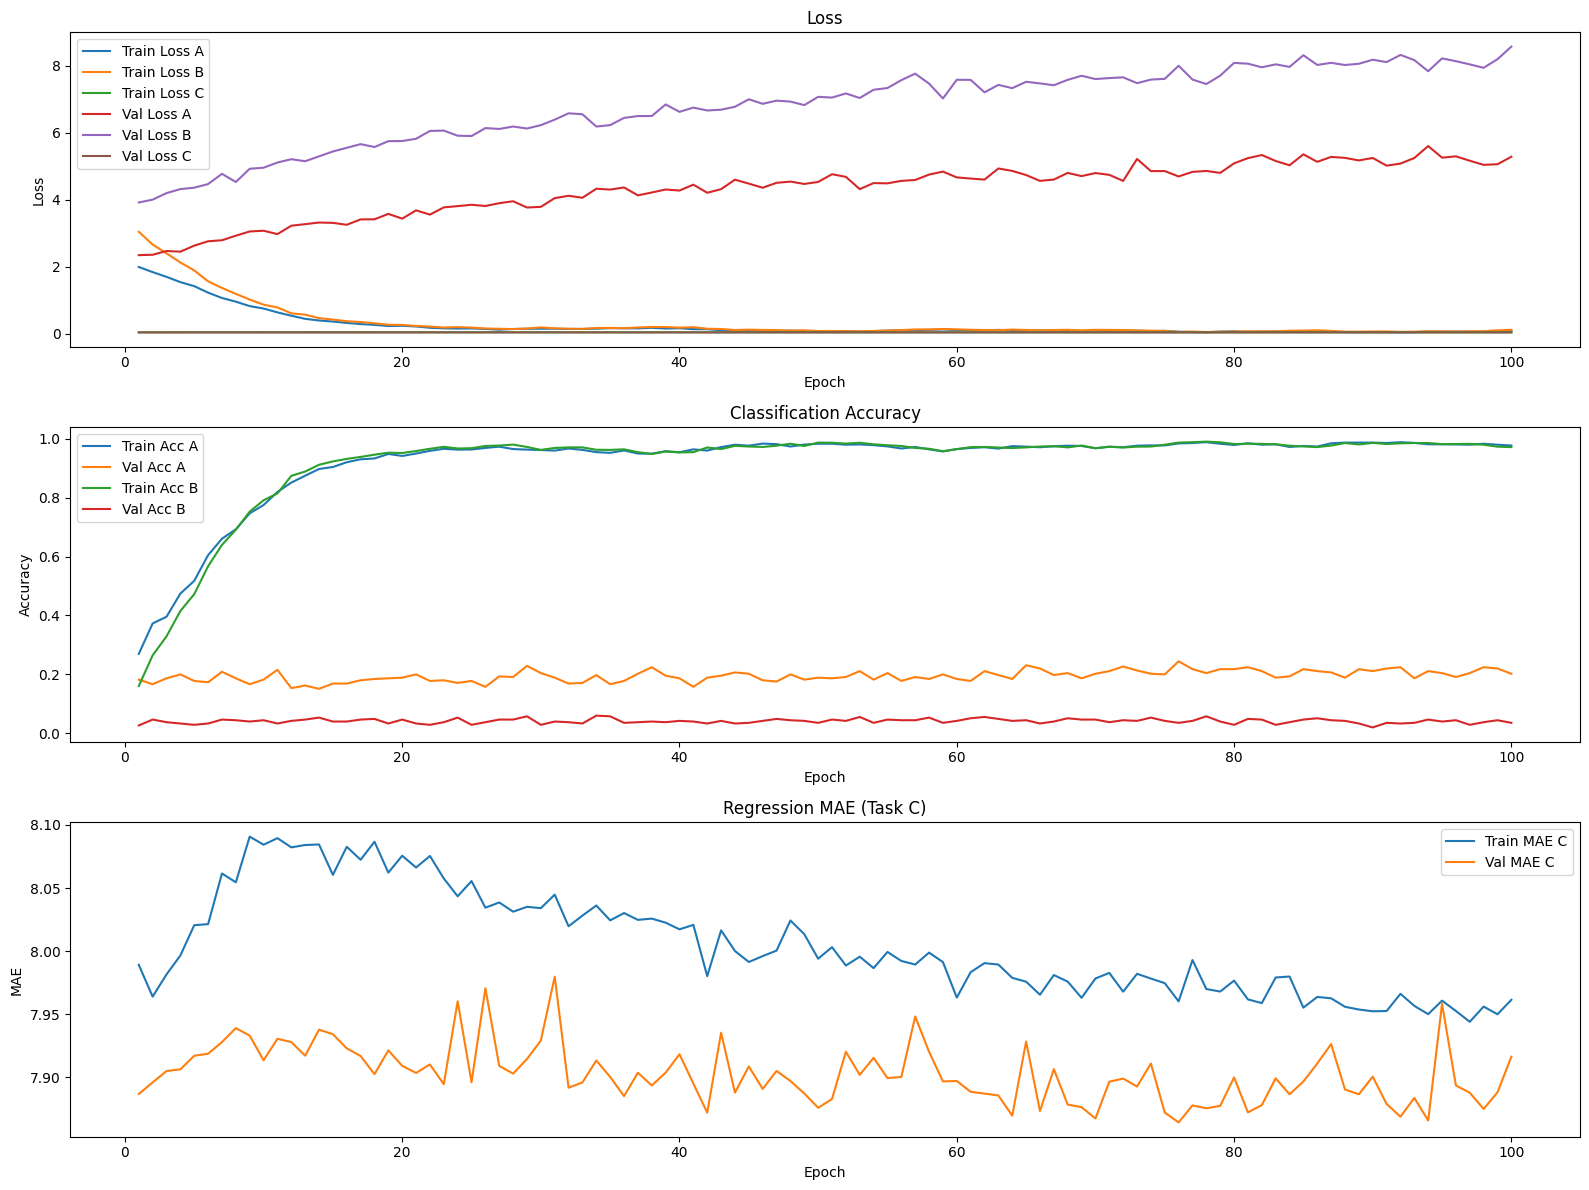

In [66]:
import matplotlib.pyplot as plt

epochs = range(1, FULL_EPOCHS + 1)

plt.figure(figsize=(16, 12))

# Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses_A, label='Train Loss A')
plt.plot(epochs, train_losses_B, label='Train Loss B')
plt.plot(epochs, train_losses_C, label='Train Loss C')
plt.plot(epochs, val_losses_A, label='Val Loss A')
plt.plot(epochs, val_losses_B, label='Val Loss B')
plt.plot(epochs, val_losses_C, label='Val Loss C')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy A & B
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accA_list, label='Train Acc A')
plt.plot(epochs, val_accA_list, label='Val Acc A')
plt.plot(epochs, train_accB_list, label='Train Acc B')
plt.plot(epochs, val_accB_list, label='Val Acc B')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# MAE C
plt.subplot(3, 1, 3)
plt.plot(epochs, train_maeC_list, label='Train MAE C')
plt.plot(epochs, val_maeC_list, label='Val MAE C')
plt.title('Regression MAE (Task C)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## 5 - Model Architecture Reasoning


This architecture uses multi-task learning with shared early layers.

The shared backbone itself is shallow. It consists of two convolutional blocks with ReLU activation, batch normalization, and max pooling. The first convolutional layer with 32 filters primarily captures low-level features such as edges and textures. The second layer with 64 filters captures more complex patterns. Batch normalization stabilizes the distribution of activations. Max pooling condenses the spatial data. The “shared_block” activation layer does not alter the values but marks a semantic boundary. Everything before it is a generic signal representation, and everything after it is task-specific specialization.

From this shared representation, each task has its own branch matched to its difficulty. Task A (10-class) is simpler, so its head is shallow with one extra convolutional layer, global average pooling, and a small dense layer. Task B (32-class) is two successive 128-filter convolutional layers to extract more abstract and discriminative features, since this task has far more layers to classify. After batch normalization and global average pooling, a larger dense layer with 256 units is used to model the higher-dimensional class structure. The same regularization mechanisms, L2 penalty and dropout, are added to prevent overfitting. In effect, Task B receives more representational power to deal with its greater difficulty while still benefiting from shared low-level filters learned jointly with Tasks A and C. Task C is regression, so its branch is lightweight and ends with a linear output appropriate for continuous values. Batch normalization, dropout, L2 regularization, and global average pooling collectively help improve generalization on noisy data.

In [88]:
inputs = tf.keras.Input(shape=(32, 32, 1), name="input_image")

# Shared
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

shared = layers.Activation('linear', name="shared_block")(x)

# Task A (10-class)
a = layers.Conv2D(128, 3, padding='same', activation='relu')(shared)
a = layers.BatchNormalization()(a)
a = layers.GlobalAveragePooling2D()(a)
a = layers.Dense(
    128, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(a)
a = layers.Dropout(0.5)(a)
output_A = layers.Dense(10, activation='softmax', name='output_A')(a)

# Task B (32-class)
b = layers.Conv2D(128, 3, padding='same', activation='relu')(shared)
b = layers.BatchNormalization()(b)
b = layers.Conv2D(128, 3, padding='same', activation='relu')(b)
b = layers.BatchNormalization()(b)
b = layers.GlobalAveragePooling2D()(b)
b = layers.Dense(
    256, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(b)
b = layers.Dropout(0.5)(b)
output_B = layers.Dense(32, activation='softmax', name='output_B')(b)

# Task C (Regression)
c = layers.Conv2D(64, 3, padding='same', activation='relu')(shared)
c = layers.BatchNormalization()(c)
c = layers.GlobalAveragePooling2D()(c)
c = layers.Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(c)
output_C = layers.Dense(1, activation='linear', name='output_C')(c)

# Model
model = tf.keras.Model(
    inputs=inputs,
    outputs=[output_A, output_B, output_C]
)


# 6. Option B — Train from scratch:

When compiled, each output uses a loss that matches its problem type. Sparse Categorical Crossentropy is chosen for Tasks A and B because their labels are stored as integers rather than one-hot vectors. Huber loss is used for Task C because it can adapt to error and use MSE (Mean Squared Error), and MAE (Mean Absolute Error), which is useful to handle outliers when regression targets from signals occasionally contain extreme values.

The loss_weights balance how strongly each task influences shared feature learning: Task B (harder, 32 classes) is emphasized more, Task C (regression) is down-weighted, and Task A remains neutral. Metrics also match task type: accuracy for classification and MAE for regression.

In [89]:
def compile_model(model, lr):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'output_A': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_B': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_C': tf.keras.losses.Huber()
        },
        loss_weights={
            'output_A': 1.0,
            'output_B': 2.0,
            'output_C': 0.3
        },
        metrics={
            'output_A': ['accuracy'],
            'output_B': ['accuracy'],
            'output_C': ['mae']
        }
    )


A warm-up training strategy with freezing then unfreezing layers is used to prevent early overfitting from the shared layer.

In the first phase, the shared layers are frozen and only the task-specific heads are trained for about 20 epochs. During this stage, each output head learns how to map already-extracted shallow features to its labels without changing the shared backbone. This prevents unstable gradients from multiple tasks from distorting the shared representation too early, which is important when tasks have different difficulty levels or loss scales.

After warm-up, the shared layers are unfrozen and the whole network is trained end-to-end for about 100 epochs. Now the model fine-tunes the shared feature extractor using informed gradients from task heads that already have reasonable behavior.

In [90]:
steps_per_epoch      = len(X_train) // BATCH_SIZE
validation_steps     = len(X_val)   // BATCH_SIZE

# Freeze shared block
model.get_layer("shared_block").trainable = False

compile_model(model, lr=1e-3)

print("Starting WARM-UP training...")

history_warmup = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)


Starting WARM-UP training...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 9.3409 - output_A_accuracy: 0.1596 - output_A_loss: 2.2789 - output_B_accuracy: 0.0294 - output_B_loss: 3.5078 - output_C_loss: 0.0344 - output_C_mae: 0.2070 - val_loss: 9.9559 - val_output_A_accuracy: 0.1077 - val_output_A_loss: 2.7397 - val_output_B_accuracy: 0.0359 - val_output_B_loss: 3.5921 - val_output_C_loss: 0.0487 - val_output_C_mae: 0.2619
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9459 - output_A_accuracy: 0.2428 - output_A_loss: 2.0888 - output_B_accuracy: 0.0595 - output_B_loss: 3.4085 - output_C_loss: 0.0149 - output_C_mae: 0.1366 - val_loss: 11.7538 - val_output_A_accuracy: 0.1388 - val_output_A_loss: 4.0413 - val_output_B_accuracy: 0.0287 - val_output_B_loss: 3.8455 - val_output_C_loss: 0.0424 - val_output_C_mae: 0.2451
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7054 - output_A_accuracy: 0.2471 - output_A_loss: 2.0173 - output_B_accuracy: 0.0664 - 

In [91]:
def compile_model(model, lr):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'output_A': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_B': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_C': tf.keras.losses.Huber()
        },
        loss_weights={
            'output_A': 1.0,
            'output_B': 2.0,
            'output_C': 0.3
        },
        metrics={
            'output_A': ['accuracy'],
            'output_B': ['accuracy'],
            'output_C': ['mae']
        }
    )



In [92]:
model.get_layer("shared_block").trainable = True
compile_model(model, lr=3e-4)

Next, we train the model for 100 epochs

In [93]:
history_finetune = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-5
        )
    ],
    verbose=1
)


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - loss: 1.4309 - output_A_accuracy: 0.8804 - output_A_loss: 0.4613 - output_B_accuracy: 0.8759 - output_B_loss: 0.4582 - output_C_loss: 0.0041 - output_C_mae: 0.0725 - val_loss: 14.0427 - val_output_A_accuracy: 0.2943 - val_output_A_loss: 2.5199 - val_output_B_accuracy: 0.0502 - val_output_B_loss: 5.6070 - val_output_C_loss: 0.0129 - val_output_C_mae: 0.1286 - learning_rate: 3.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8847 - output_A_accuracy: 0.9209 - output_A_loss: 0.3457 - output_B_accuracy: 0.9476 - output_B_loss: 0.2448 - output_C_loss: 0.0029 - output_C_mae: 0.0599 - val_loss: 15.0945 - val_output_A_accuracy: 0.2584 - val_output_A_loss: 2.7431 - val_output_B_accuracy: 0.0359 - val_output_B_loss: 6.0653 - val_output_C_loss: 0.0137 - val_output_C_mae: 0.1225 - learning_rate: 3.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7227 - output_A_accuracy: 0.9521 - output_A_loss: 0.2838

The final training results of the multi-task model showcase a high accuracy, and low loss in three tasks, but there is a very strong discrepancy between training and validation performance. On the training set, the model reaches almost perfect accuracy for both classification tasks and very low error for regression, meaning the network successfully fits the training data. However, validation accuracy remains low (32.5% for Task A and 6.2% for Task B), while validation losses are very high. This is a symptom of overfitting: the model memorizes patterns present in the training samples but does not generalize well to unseen data.

The dominant reason for this behavior lies in the nature and quality of the dataset rather than the model alone. The dataset may contain several inherent challenges, such as high noise levels in samples (signal-like patterns with irregular shapes), and label separability between classes' insignificant difference.

Under these conditions, achieving high accuracy is unrealistic. Instead, the focus is on explaining why performance is limited.

After several experiments, we have drawn out that the dataset is difficult, and the model reaches the theoretical limits imposed by data quality rather than by architecture alone. The experiment demonstrates that even with multiple network architectures, regularization technique, and warm-up training strategy, the model still overfits.

In [94]:
import matplotlib.pyplot as plt

def plot_task_losses(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history['output_A_loss'], label='Train A Loss')
    plt.plot(history['val_output_A_loss'], label='Val A Loss')

    plt.plot(history['output_B_loss'], label='Train B Loss')
    plt.plot(history['val_output_B_loss'], label='Val B Loss')

    plt.plot(history['output_C_loss'], label='Train C Loss')
    plt.plot(history['val_output_C_loss'], label='Val C Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Multi-task Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


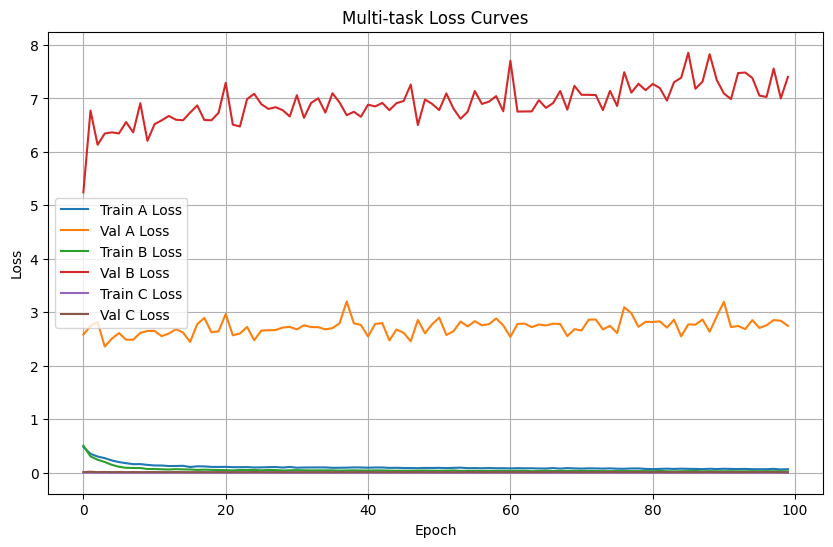

In [75]:
plot_task_losses(history_finetune.history)


In [95]:
def plot_all_tasks(history):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Task A
    axs[0].plot(history['output_A_accuracy'], label='Train')
    axs[0].plot(history['val_output_A_accuracy'], label='Val')
    axs[0].set_title('Task A Accuracy')
    axs[0].legend()
    axs[0].grid()

    # Task B
    axs[1].plot(history['output_B_accuracy'], label='Train')
    axs[1].plot(history['val_output_B_accuracy'], label='Val')
    axs[1].set_title('Task B Accuracy')
    axs[1].legend()
    axs[1].grid()

    # Task C
    axs[2].plot(history['output_C_mae'], label='Train')
    axs[2].plot(history['val_output_C_mae'], label='Val')
    axs[2].set_title('Task C MAE')
    axs[2].legend()
    axs[2].grid()

    plt.show()


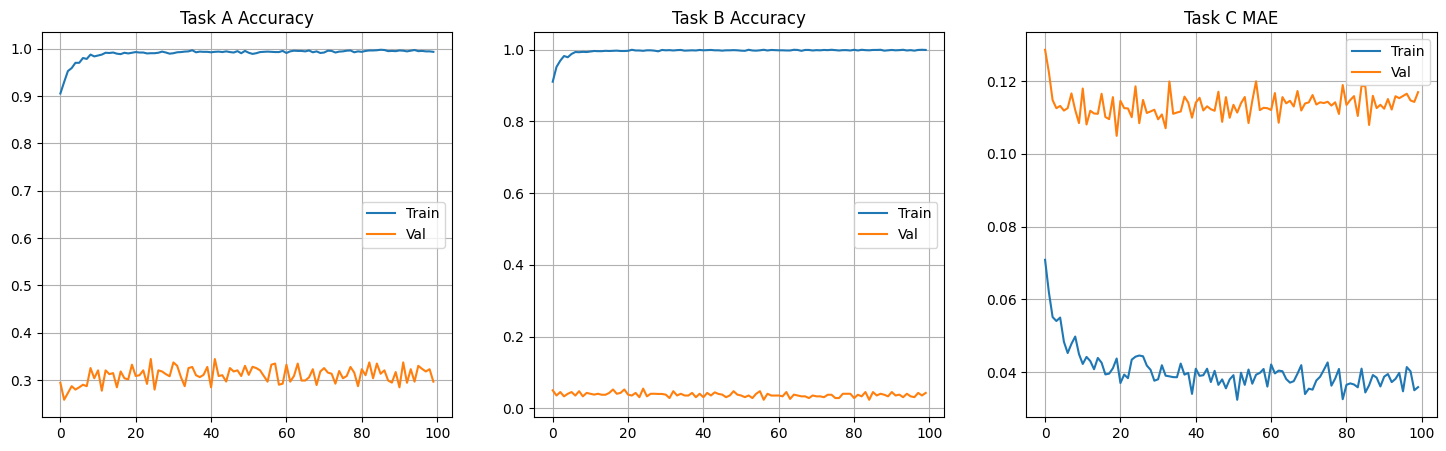

In [96]:
plot_all_tasks(history_finetune.history)

In [97]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get model predictions
preds = model.predict(X_test)  # returns [outA, outB, outC] for multitask

outA_pred, outB_pred, outC_pred = preds

# Convert probabilities → class labels
yA_pred = np.argmax(outA_pred, axis=1)
yB_pred = np.argmax(outB_pred, axis=1)

# True labels
yA_true = yA_val
yB_true = yB_val

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


In [98]:
cm_A = confusion_matrix(yA_true, yA_pred)
cm_B = confusion_matrix(yB_true, yB_pred)

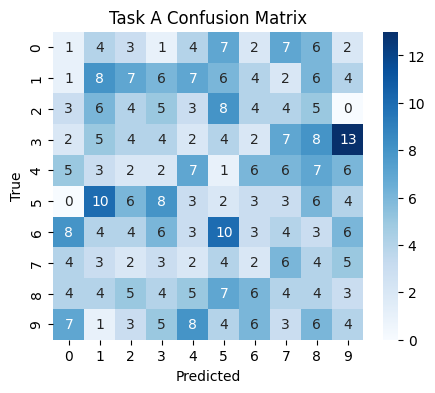

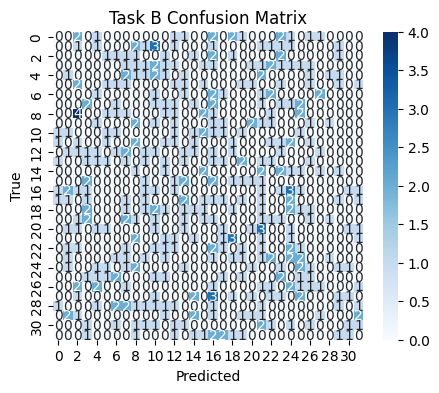

In [99]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(cm_A, "Task A Confusion Matrix")
plot_confusion_matrix(cm_B, "Task B Confusion Matrix")


In [100]:
model.save("submission_s4021255_s3978616.h5")


# 7. Option A — Load trained model

Here, we load our model for prediction

In [101]:
from tensorflow.keras.models import load_model

model = load_model("submission_s4021255_s3978616.h5")

This function takes the X-input batch and predict using the loaded model. Note that this function takes the image batch that has been preprocessed already. If the image batch has not been preprocessed, take the **predict_multitask_preprocessed** function below instead.

In [102]:
import numpy as np

def predict_multitask(model, X_input, max_pixel_value):
    """
    X_input: single image (32x32) or batch (N,32,32)
    max_pixel_value: SAME value used during training normalization
    """

    pred_A, pred_B, pred_C = model.predict(X_input)

    # 6. Post-processing
    class_A = np.argmax(pred_A, axis=1)   # 0–9
    class_B = np.argmax(pred_B, axis=1)   # 0–31
    value_C = pred_C.reshape(-1)          # regression values

    return class_A, class_B, value_C


Here, we predict label for the three classes using the sample test set, then check accuracy, MAE, and MSE score. The result is very similar to the validation score.

In [104]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

MAX_PIXEL_VALUE = 1

# Get predictions
classA_pred, classB_pred, valueC_pred = predict_multitask(model, X_test, MAX_PIXEL_VALUE)

# Task A Accuracy
acc_A = accuracy_score(yA_test, classA_pred)

# Task B Accuracy
acc_B = accuracy_score(yB_test, classB_pred)

# Task C Regression Metrics
mae_C = mean_absolute_error(yC_test_reg, valueC_pred)
mse_C = mean_squared_error(yC_test_reg, valueC_pred)

print("Task A Accuracy:", acc_A)
print("Task B Accuracy:", acc_B)
print("Task C MAE:", mae_C)
print("Task C MSE:", mse_C)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Task A Accuracy: 0.30444444444444446
Task B Accuracy: 0.05333333333333334
Task C MAE: 0.12402799672498885
Task C MSE: 0.024991524249399308


This function can be used to predict image batch that has not been preprocessed.

In [ ]:
import numpy as np

def predict_multitask_preprocessing(model, X_input, max_pixel_value):
    """
    X_input: single image (32x32) or batch (N,32,32)
    max_pixel_value: SAME value used during training normalization
    """

    # 1. Convert to numpy
    X_input = np.array(X_input, dtype=np.float32)

    # 2. Ensure batch dimension
    if X_input.ndim == 2:
        # (32,32) -> (1,32,32,1)
        X_input = np.expand_dims(X_input, axis=0)
    elif X_input.ndim == 3:
        # (N,32,32) -> (N,32,32,1)
        pass
    else:
        raise ValueError("Input must be shape (32,32) or (N,32,32)")

    # 3. Normalize exactly like training
    X_norm = X_input / max_pixel_value

    # 4. Add channel dimension if missing
    if X_norm.ndim == 3:
        X_norm = np.expand_dims(X_norm, axis=-1)

    # Now shape should be (N,32,32,1)

    # 5. Run model
    pred_A, pred_B, pred_C = model.predict(X_norm)

    # 6. Post-processing
    class_A = np.argmax(pred_A, axis=1)   # 0–9
    class_B = np.argmax(pred_B, axis=1)   # 0–31
    value_C = pred_C.reshape(-1)          # regression values

    return class_A, class_B, value_C


Sample prediction, remember to load the data before testing

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# Get predictions
classA_pred, classB_pred, valueC_pred = predict_multitask_preprocessing(model, X_test, MAX_PIXEL_VALUE)

# Task A Accuracy
acc_A = accuracy_score(yA_test, classA_pred)

# Task B Accuracy
acc_B = accuracy_score(yB_test, classB_pred)

# Task C Regression Metrics
mae_C = mean_absolute_error(yC_test_reg, valueC_pred)
mse_C = mean_squared_error(yC_test_reg, valueC_pred)

print("Task A Accuracy:", acc_A)
print("Task B Accuracy:", acc_B)
print("Task C MAE:", mae_C)
print("Task C MSE:", mse_C)
